## Testing TIR image resolution with simulated forest scenes
***

In [7]:
import numpy as np
import math
import cv2

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

#### Define scaling and plotting functions:

In [2]:
def create_histogram(image, n_bins=None, low_threshold=None, high_threshold=None):
    '''creates a single image's histogram  '''
    # reshape the image pixel array
    image = image.reshape(-1);
    # remove NaN values
    image = image[~np.isnan(image)];
    # apply low_threshold:
    if low_threshold is not None:
        image = image[image>low_threshold]
    if high_threshold is not None:
        image = image[image<high_threshold]
    # create the histogram:
    if n_bins is None:
        n_bins = 10 # bin width should be set to accuracy of the camera? +/- 1 C
    count, value = np.histogram(image, bins=n_bins); 
    # take the bin edges (value) and change them to bin centers
    # so that number of "count" = number of "value"
    new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
    value = new_value
    count_stddev = np.std(count)
    return [value, count]



def movingAverage(data,N):
    '''Calculate a moving average across a 2d array (data) with window size of NxN'''
    new_shape_0 = int(data.shape[0]/N)
    new_shape_1 = int(data.shape[1]/N)

    result = np.ones((new_shape_0,new_shape_1))

    for x in range(1,new_shape_0+1):
        for y in range(1,new_shape_1+1):
            T = data[(x-1)*N:x*N,(y-1)*N:y*N] # the array of all pixel temperatures within the NxN window
            result[x-1,y-1] = np.mean(T) # simple mean of all pixel temperatures in the window

    return result



def upscaling_routines(original_image,px_size,target_res,make_plots=False):

    image_corrected = original_image
    
    
    # Simple mean aggregation
    # approx how many pixels do we need to average together to get to our target pixel size?
    n_px_agg = int((target_res / px_size))
    m_new_res = n_px_agg * px_size # our new resolution will be n number of pixels times the original resolution
    mean_agg = movingAverage(image_corrected,n_px_agg)
       
    
    # Gaussian pyramid (5x5 convolution kernel)
    # See docs here: https://docs.opencv.org/3.1.0/d4/d86/group__imgproc__filter.html#gaf9bba239dfca11654cb7f50f889fc2ff
    steps = int(np.round(np.log(target_res/px_size)/(np.log(2)))) # how many steps to take to get (close) to target resolution
    g_new_res = px_size * 2**steps # what the actual new resolution will be
    lower_res = image_corrected # start with the original image, each iteration makes it lower resolution
    for i in range(0,steps):
        lower_res = cv2.pyrDown(lower_res) # iterate using pyrDown the number of steps we need
    gaussian_upscaled = lower_res
    #print("gaussian upscaled std dev:",np.std(gaussian_upscaled))

    ### Plots
    if make_plots == True:
        plt.figure(figsize=(27,10))
        
        v_min = -2; #np.min(image_corrected)
        v_max = 20; #np.max(image_corrected)
        
        plt.subplot(241)
        plt.imshow(image_corrected,vmin=v_min,vmax=v_max,cmap='magma')
        plt.title("original image: " + str(np.round(px_size,2)))
        plt.subplot(245)
        original_hist = create_histogram(image_corrected)
        #plt.plot(original_hist[0],original_hist[1]/np.sum(original_hist[1]),'-k',label='original')
        cleanhist(image_corrected)
        
        plt.subplot(242)
        plt.imshow(gaussian_upscaled,vmin=v_min,vmax=v_max,cmap='magma')
        plt.title("pyrDown upscaled image: " + str(np.round(g_new_res,2)))
        plt.subplot(246)
        gaussian_hist = create_histogram(gaussian_upscaled)
        #plt.plot(gaussian_hist[0],gaussian_hist[1]/np.sum(gaussian_hist[1]),'-k',label='gaussian pyramid')
        cleanhist(gaussian_upscaled)
        
        plt.subplot(243)
        plt.imshow(mean_agg,vmin=v_min,vmax=v_max,cmap='magma')
        plt.title("mean aggregated image: " + str(np.round(m_new_res,2)))
        plt.colorbar()
        plt.subplot(247)
        mean_agg_hist = create_histogram(mean_agg)
        #plt.plot(mean_agg_hist[0],mean_agg_hist[1]/np.sum(mean_agg_hist[1]),'-k',label='simple average')
        cleanhist(mean_agg)

    # get the mean temperature at the center of the image
    temp_a = np.mean(gaussian_upscaled[int(np.floor(gaussian_upscaled.shape[0]/2)),int(np.floor(gaussian_upscaled.shape[0]/2))])
    temp_b = np.mean(mean_agg[int(np.floor(mean_agg.shape[0]/2)),int(np.floor(mean_agg.shape[0]/2))])
        
    return gaussian_upscaled, mean_agg


def cleanhist(x, n_bins=None,lower_limit=-2,upper_limit=25):
    '''a histogram plotting function with some formatting'''
    if n_bins is None:
        n_bins = 10
    count, value = np.histogram(x, bins=n_bins); 
    # take the bin edges (value) and change them to bin centers
    # so that number of "count" = number of "value"
    new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
    value = new_value
       
    median_x = np.median(x)
    mean_x = np.mean(x)
    mode_x = value[count.argmax()]  
    #print('Mean:\t%f\nMedian:\t%f\nMode:\t%f' % (mean_x, median_x, mode_x))

    percent = (count/(x.shape[0]*x.shape[1]))*100
    #fig = plt.figure(figsize=(5,5),frameon=False)
    #ax = fig.add_subplot(1, 1, 1)
    #plt.hist(x,bins=n_bins,label='Temperature Histogram',color='lightgray');
    plt.fill_between(value,percent,0,color='0.5',alpha=0.1)
    plt.plot(np.linspace(0,0,10),np.linspace(0,np.max(percent)+1,10),'-',c='lightgray',label='0 C', linewidth=1)
    plt.plot(value,percent,'-k', linewidth=1)
    #ax.plot(np.linspace(median_x,median_x,10),np.linspace(0,15,10),'--k',label='Median Temp.')
    #ax.plot(np.linspace(mean_x,mean_x,10),np.linspace(0,15,10),'-k',label='Mean Temp.')
    #ax.plot(np.linspace(np.min(value),np.max(value),10),np.linspace(0,0,10),':k',label='0 C')
    #ax.text(mean_x,14,str(np.round(mean_x,2)))
    #ax.text(median_x,12,str(np.round(median_x,2)))
    plt.xlabel('Temperature (C)')
    plt.ylabel('Percent of Image Area')    
    plt.ylim((0,0))
    plt.xlim((lower_limit,upper_limit))
    plt.tight_layout()
    #plt.legend()

#### Define functions for creating simulated forest images:

In [5]:
def dist(x1, y1, x2, y2):
    d = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    return d

def make_circle_grid(pixel_array,n,m,r,object_value):
    '''make a grid of n by m evenly spaced circles each with radius r'''
    col_size = pixel_array.shape[0]/(n+1)
    row_size = pixel_array.shape[1]/(m+1)
    #print(col_size, row_size)
    for column in range(0,n+1):
        for row in range(0,m+1):
            cx = int((column) * (col_size))
            cy = int((row) * (row_size))
            for x in range(cx - r, cx + r):
                for y in range(cy - r, cy + r):
                    if dist(cx, cy, x, y) <= r:
                        pixel_array[x][y] = object_value
    return pixel_array

def make_single_tree(pixel_array,r,object_value):
    '''make a single large tree cluster at image center with radius r'''
    cx = int(pixel_array.shape[0]/2)
    cy = int(pixel_array.shape[1]/2)
    for x in range(cx - r, cx + r):
        for y in range(cy - r, cy + r):
            if dist(cx, cy, x, y) <= r:
                pixel_array[x][y] = object_value
    return pixel_array

***
## Test a grid of small trees uniformly spaced, with increasing fveg

fveg: 0.031415926535897934
mixed fraction: [0, 1.0]
edge ratio: 50.0
fveg: 0.07068583470577035
mixed fraction: [0, 1.0]
edge ratio: 50.0
fveg: 0.12566370614359174
mixed fraction: [0, 1.0]
edge ratio: 50.0
fveg: 0.19634954084936207
mixed fraction: [0, 1.0]
edge ratio: 50.0
fveg: 0.28274333882308134
mixed fraction: [0, 1.0]
edge ratio: 50.0
fveg: 0.38484510006474965
mixed fraction: [0, 1.0]
edge ratio: 50.0
fveg: 0.5026548245743669
mixed fraction: [0, 0.99609375]
edge ratio: 50.0
fveg: 0.6361725123519332
mixed fraction: [0, 0.4765625]
edge ratio: 50.0
fveg: 0.7853981633974484
mixed fraction: [0, 0.0]
edge ratio: 50.0
fveg: 0.9503317777109124
mixed fraction: [0, 0.0]
edge ratio: 50.0


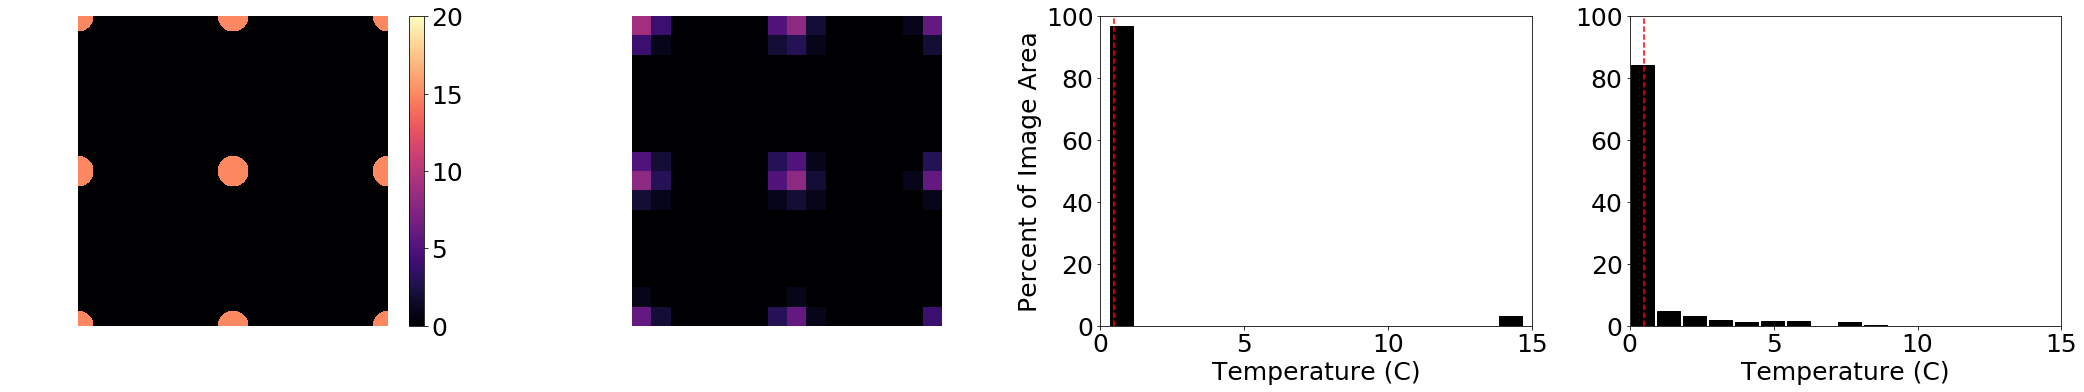

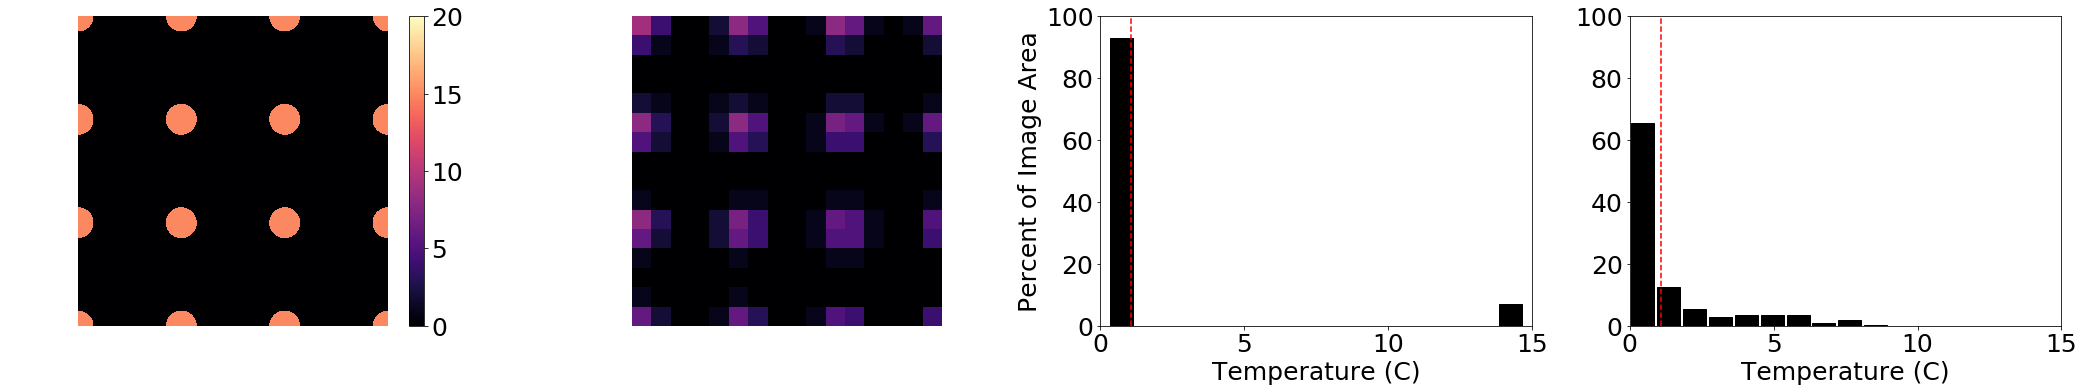

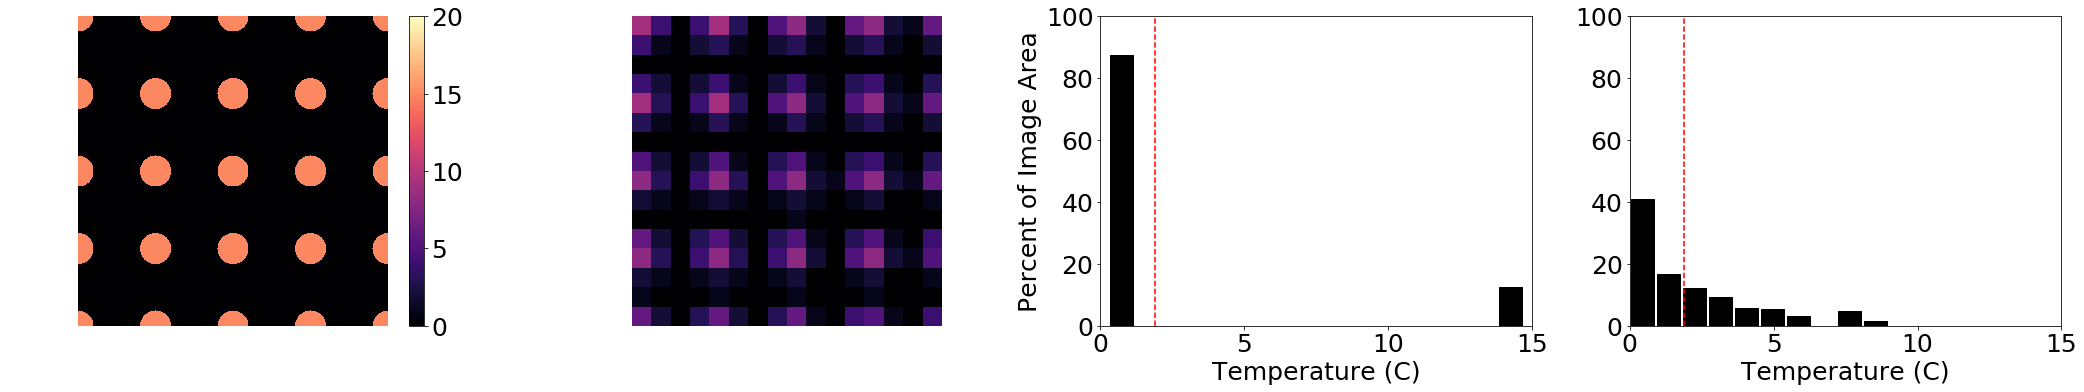

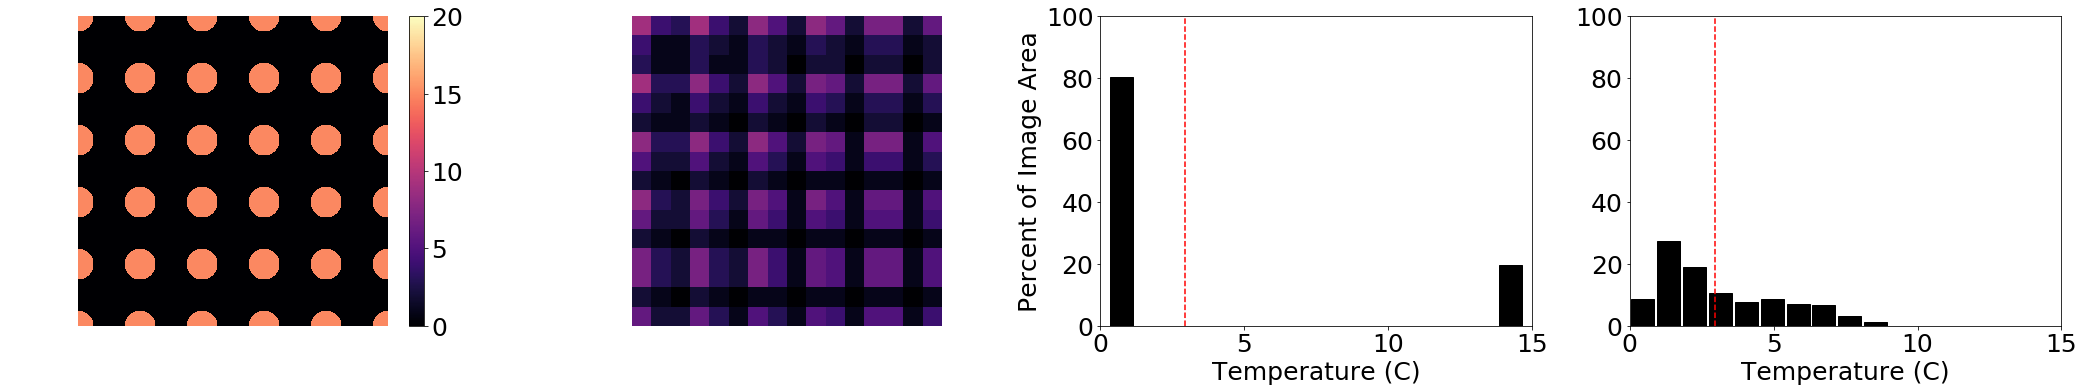

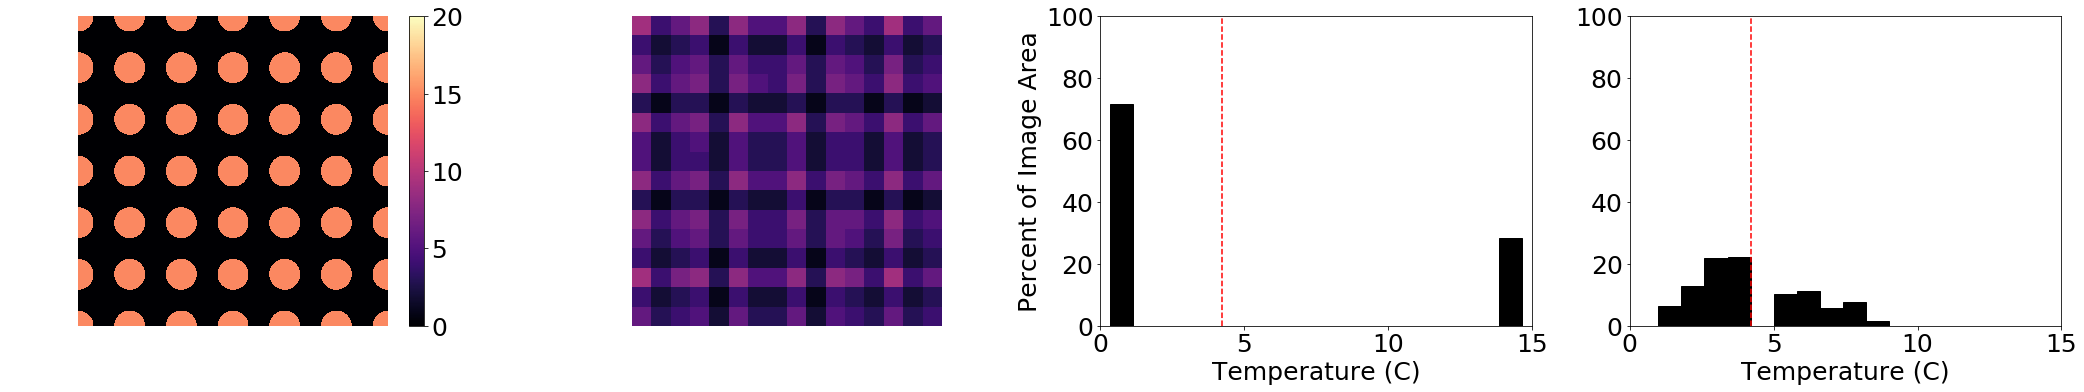

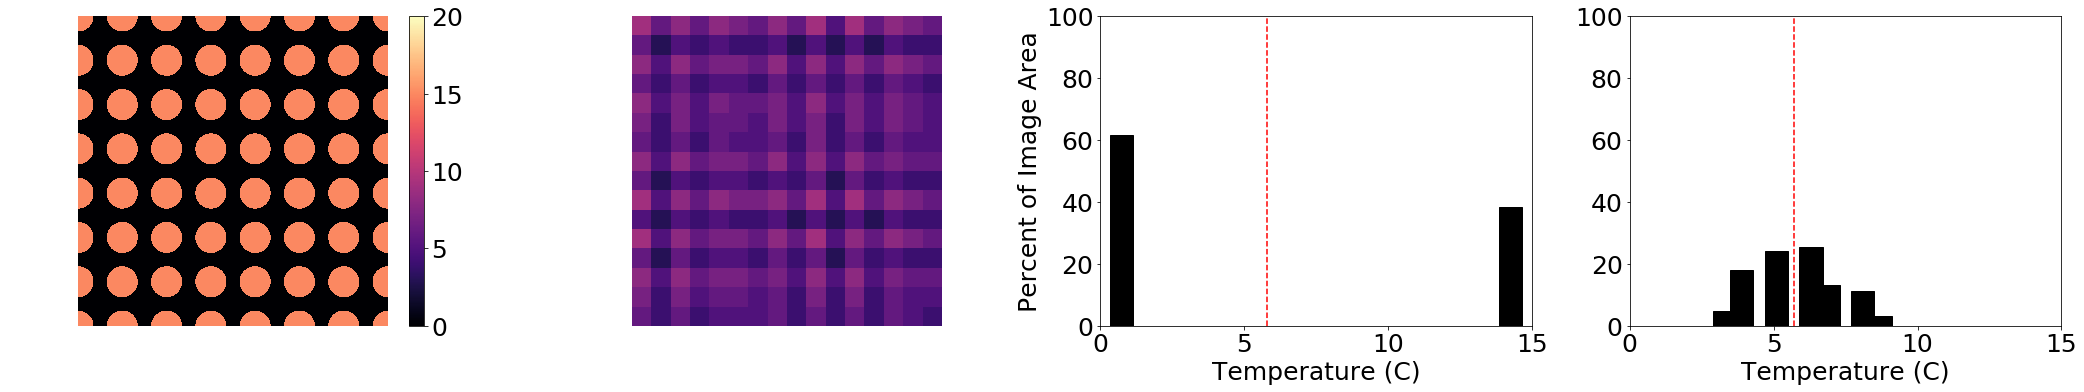

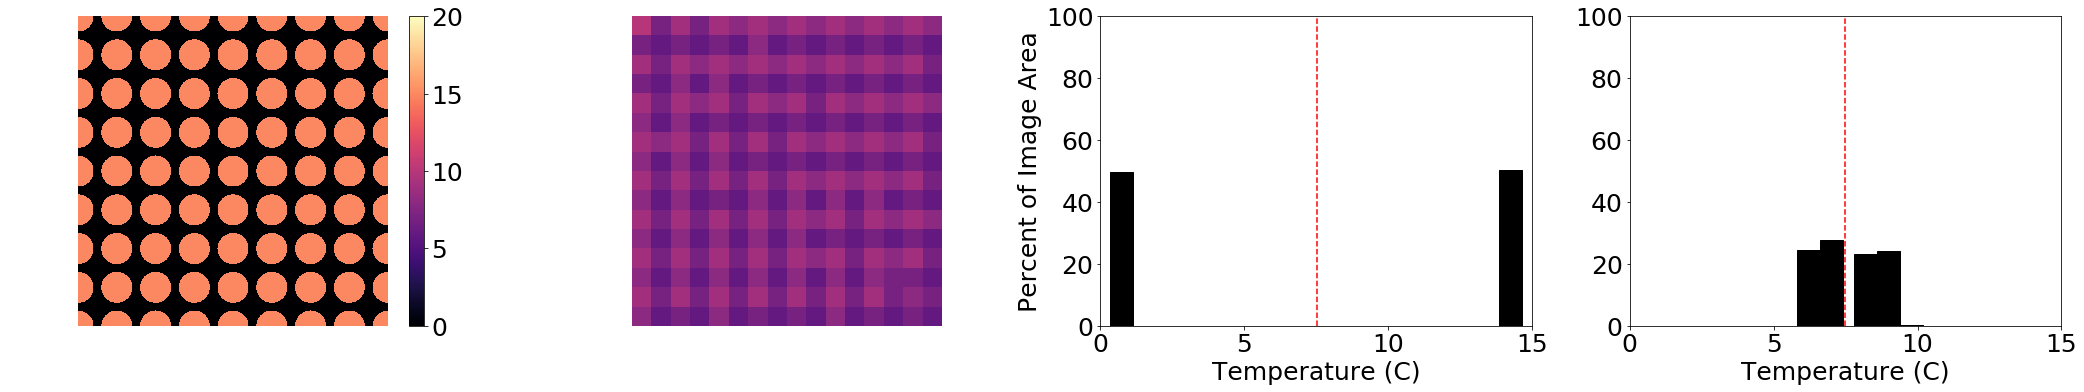

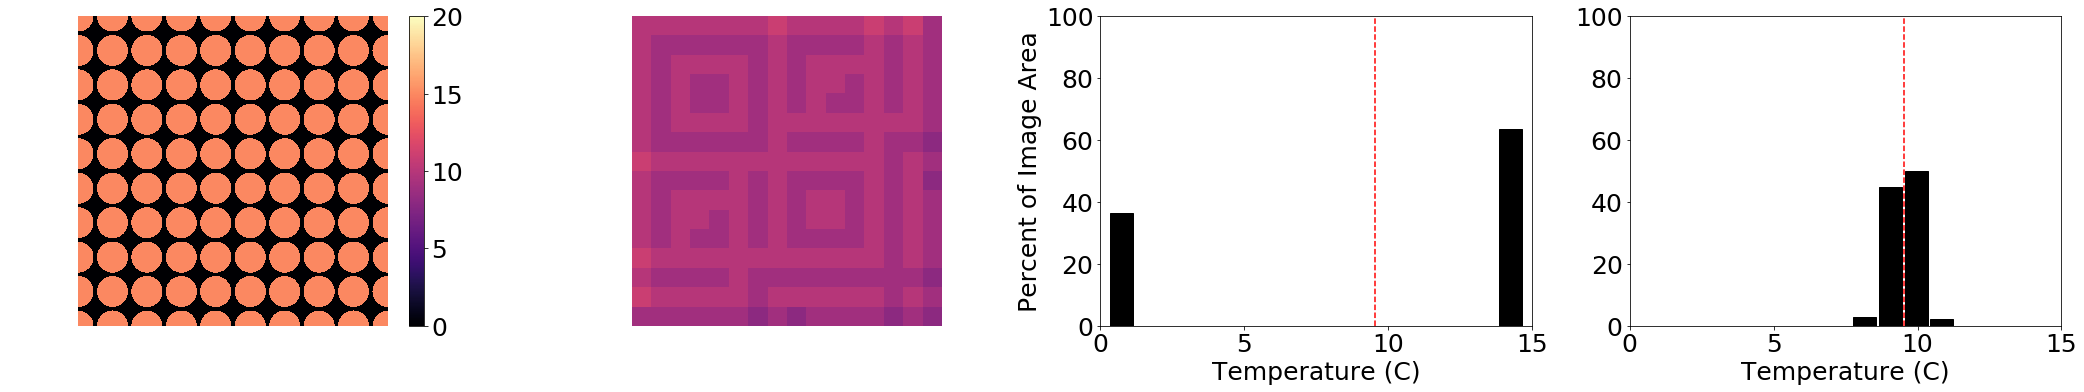

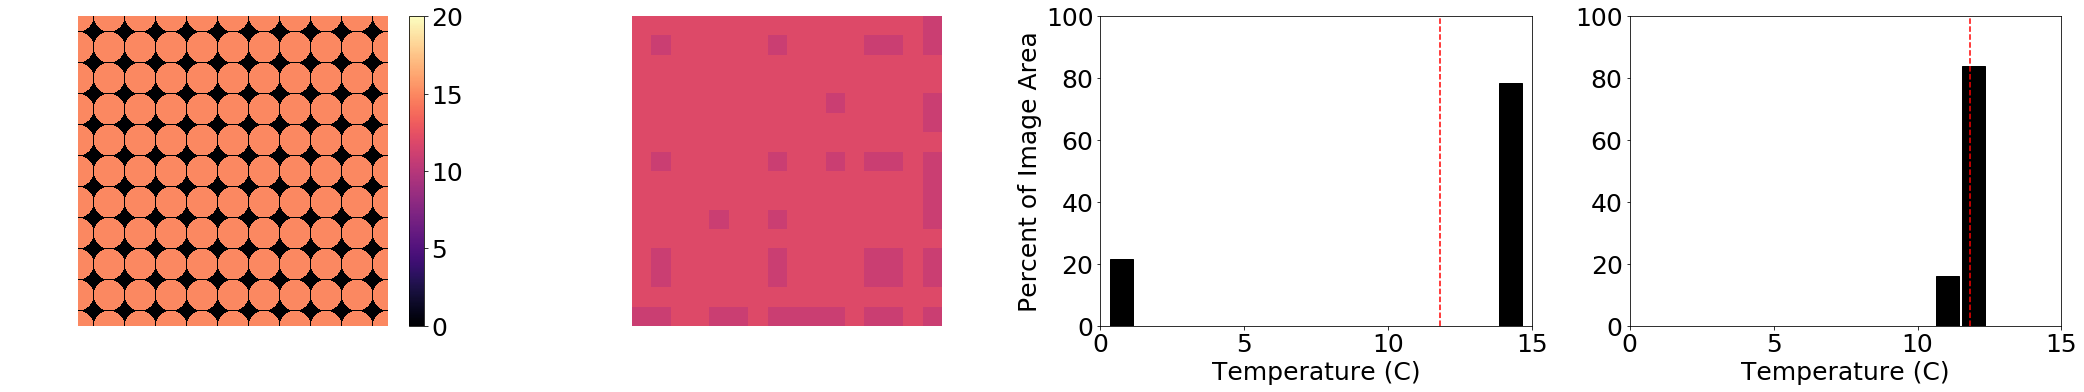

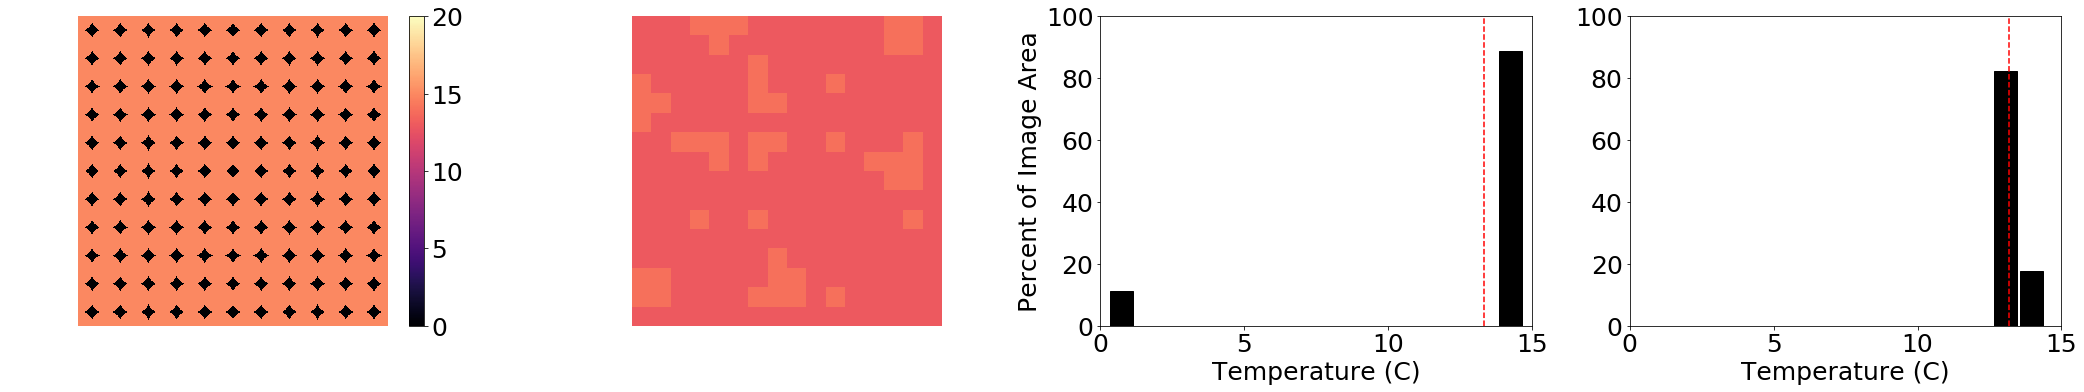

In [4]:
background_value = 0
object_value = 15

width = 2000 # units = cm
height = 2000 # units = cm

# tree radius
radius = 100

steps = [0];

# what resolution scales to test (doubling each step)
res_set = [128]

# n by n grid of trees
n_trees = np.arange(1,11,1)

# fractional vegetation area (use binary mask of original image to define)
fveg = []

plot_figures_original = True
plot_figures_gaussian = True
# update plot parameters
plt.rcParams.update({'font.size': 25})

counter = 0;
for n in n_trees:
    trees_edge_length = (n**2 + (2*n) + 1) * (2 * np.pi * radius)
    image_area = width * height # total area of the image
    tree_area = np.pi * (radius**2) # the area of one single tree
    veg_area = (tree_area * (n)**2) + (tree_area * n * 2) + tree_area # sum of all tree areas
    fveg_area = veg_area / image_area # calculate fveg
    fveg.append(fveg_area) # append to fveg array
    print('fveg:',fveg[counter])
    
    # make this image with n by n trees
    image = [[background_value for _ in range(height)] for _ in range(width)]
    image = np.array(image)
    image = image.astype(np.uint8)
    image = make_circle_grid(image,n,n,radius,object_value)
    
    # get the original image temperature values for gaussian upscaling
    mean_temp = [np.mean(image)]
    median_temp = [np.median(image)]
    std_temp = [np.std(image)]
    min_temp = [np.min(image)]
    max_temp = [np.max(image)]
    target_temp = [image[int(image.shape[0]/2),int(image.shape[1]/2)]];
    mixed_fraction = [0]
    
    if plot_figures_original == True:
        # original image plot
        plt.figure(figsize=(30,6))
        plt.subplot(141)
        plt.imshow(image,cmap='magma',vmin=0,vmax=20) # cmap='PRGn',vmin=-20,vmax=20)#
        #plt.title('$F_{veg}$ = '+str(np.round(fveg[counter],2))+ ' | MeanT = ' + str(np.round(mean_temp[0],2)));
        #plt.title('$f_{veg}$ = {}'.format(str(np.round(fveg[counter],2))))
        cb = plt.colorbar() # set up colorbar:
        tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator
        cb.update_ticks()
        plt.axis('off')
        plt.subplot(143)
        # make histogram
        count, value = np.histogram(image, bins=10); 
        percent = (count/(image.shape[0]*image.shape[1]))*100
        new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
        value = new_value
        #plt.plot(value,percent,'k--',label='True Surface Temperatures')
        plt.bar(value, percent, width=0.8, color='k', edgecolor='k')
        plt.plot(np.linspace(np.mean(image),np.mean(image),2),np.linspace(0,100,2),'r--')
        #plt.title('Mean: ' + str(np.round(np.mean(image),2)))
        plt.xticks([0,5,10,15])
        plt.ylim((0,100)); plt.xlim((0,15)); plt.ylabel('Percent of Image Area'); plt.xlabel('Temperature (C)')
    
    # upscale this image
    for res in res_set: # go from px resolution of 1 to target resolution of res
        image_upscaled, _ = upscaling_routines(image,1,res,make_plots=False);
        
        # Calculate approx pixel size in meters
        pixel_size = np.round((width/np.ceil(width/res))/100,2)
        
        if plot_figures_gaussian == True:
            
            
            # Get the upscaled temperature values
            mean_temp.append(np.mean(image_upscaled))
            median_temp.append(np.median(image_upscaled))
            std_temp.append(np.std(image_upscaled))
            min_temp.append(np.min(image_upscaled))
            max_temp.append(np.max(image_upscaled))
            target_temp.append(image_upscaled[int(image_upscaled.shape[0]/2),int(image_upscaled.shape[1]/2)])
            mixed_fraction.append(len(image_upscaled[(image_upscaled>1)&(image_upscaled<10)])/len(image_upscaled[image_upscaled>1]))
            print('mixed fraction:',mixed_fraction)
            edge_r = np.round(veg_area/trees_edge_length,2)
            print('edge ratio:',edge_r)
            
            # gaussian upscaled image
            plt.subplot(142)
            plt.imshow(image_upscaled,cmap='magma',vmin=0,vmax=20)
            #plt.title('$F_{veg}$ = '+str(np.round(fveg[counter],2))+ ' | MeanT = ' + str(np.round(mean_temp[1],2)));
            #plt.title('$f_{veg}$ = {}'.format(str(np.round(fveg[counter],2))))
            #plt.colorbar()
            plt.axis('off')
            plt.subplot(144)
            # make histogram
            count, value = np.histogram(image_upscaled, bins=10); 
            percent = (count/(image_upscaled.shape[1]*image_upscaled.shape[1]))*100
            new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
            value = new_value
            #plt.plot(value,percent,'k-',label='Observed Surface Temperatures')
            plt.bar(value, percent, width=0.8, color='k', edgecolor='k')
            plt.plot(np.linspace(np.mean(image_upscaled),np.mean(image_upscaled),2),np.linspace(0,100,2),'r--')
            #plt.title('Mean: ' + str(np.round(np.mean(image_upscaled),2)))
            plt.xticks([0,5,10,15])
            plt.ylim((0,100)); plt.xlim((0,15)); 
            #plt.ylabel('Percent of Image Area'); 
            plt.xlabel('Temperature (C)')

            plt.tight_layout()
            #plt.savefig('fveg'+str(np.round(fveg[counter],2))+ '_upscaled_withHistogram_' + str(res) + '.png',dpi=600)
        
    
    fveg_label = str(np.round(fveg[counter],2))    
    counter = counter + 1;
    

***
## Test a single large tree cluster, with increasing fveg

fveg: 0.007853981633974483
mixed fraction: [0, 1.0]
edge ratio: 50.0
fveg: 0.031415926535897934
mixed fraction: [0, 0.6470588235294118]
edge ratio: 100.0
fveg: 0.07068583470577035
mixed fraction: [0, 0.5357142857142857]
edge ratio: 150.0
fveg: 0.12566370614359174
mixed fraction: [0, 0.4222222222222222]
edge ratio: 200.0
fveg: 0.19634954084936207
mixed fraction: [0, 0.3880597014925373]
edge ratio: 250.0
fveg: 0.2827433388230814
mixed fraction: [0, 0.3191489361702128]
edge ratio: 300.0
fveg: 0.38484510006474965
mixed fraction: [0, 0.2857142857142857]
edge ratio: 350.0
fveg: 0.5026548245743669
mixed fraction: [0, 0.2662337662337662]
edge ratio: 400.0
fveg: 0.6361725123519331
mixed fraction: [0, 0.24607329842931938]
edge ratio: 450.0
fveg: 0.7853981633974483
mixed fraction: [0, 0.13963963963963963]
edge ratio: 500.0


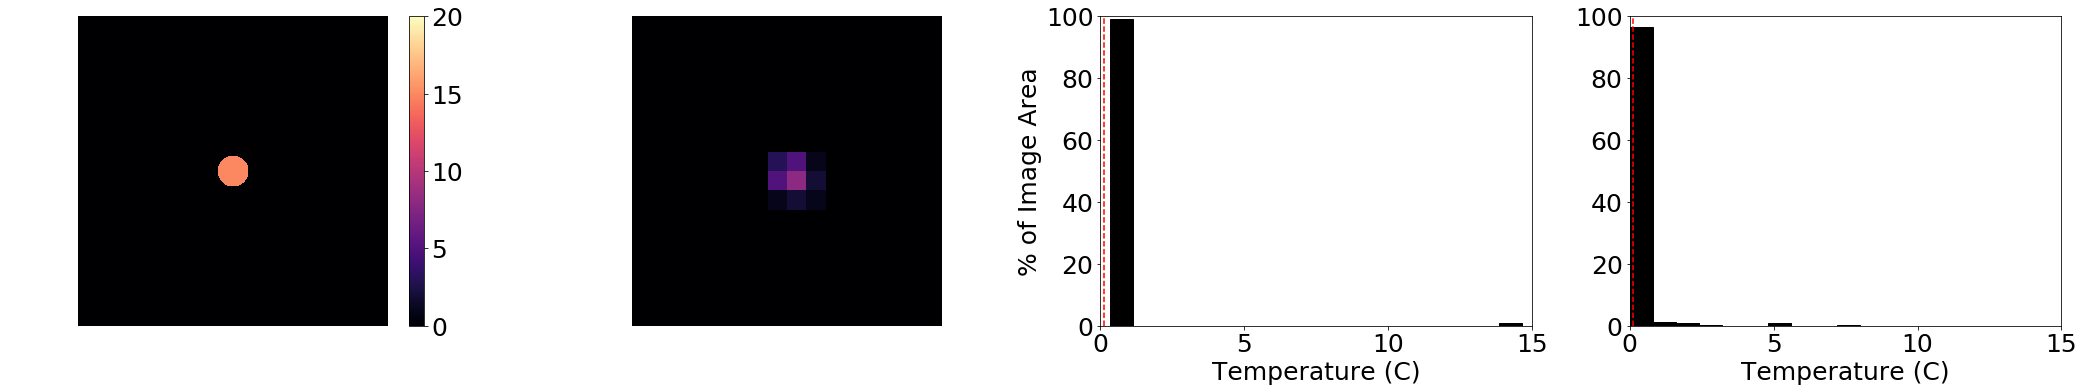

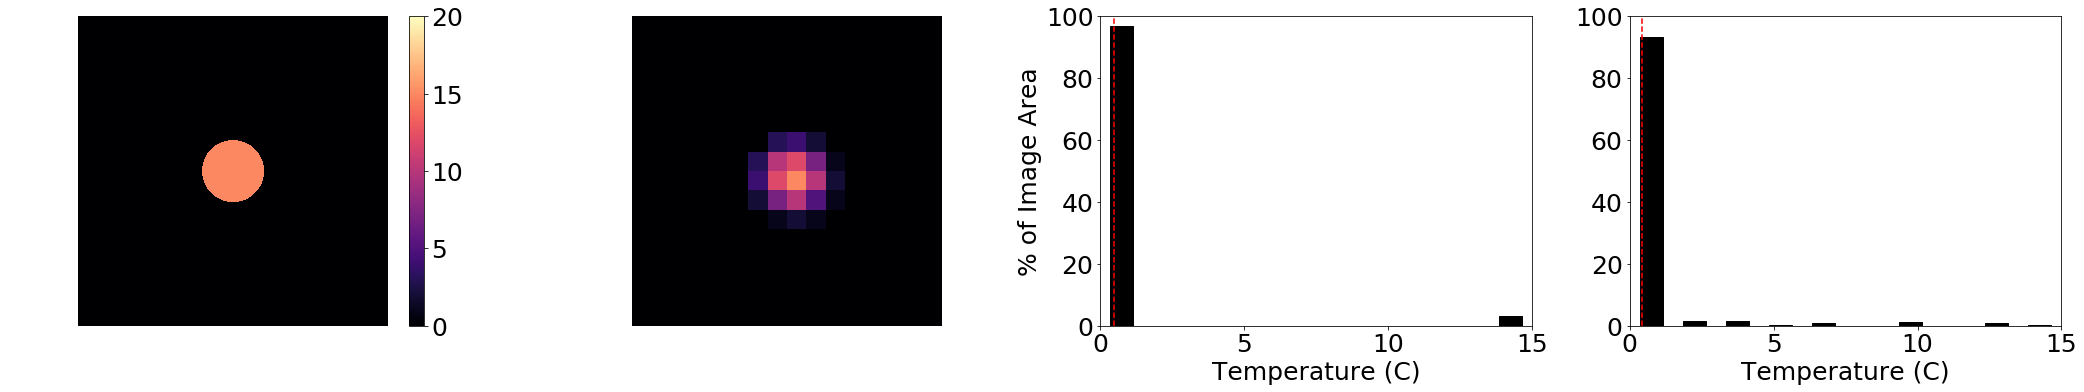

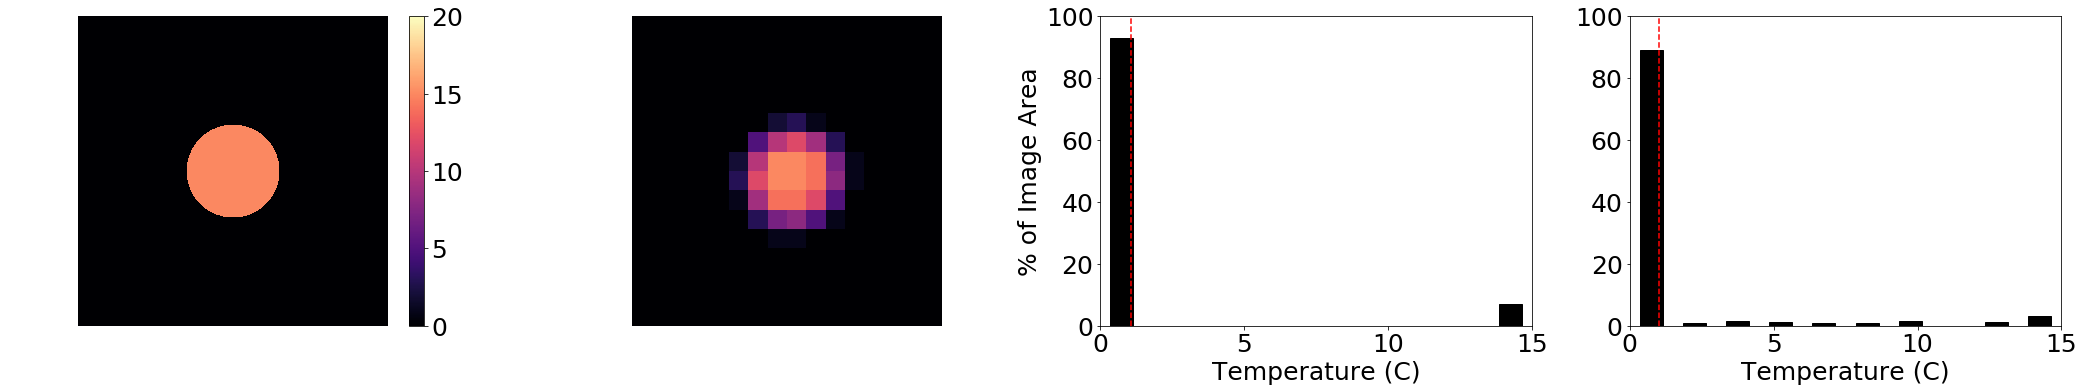

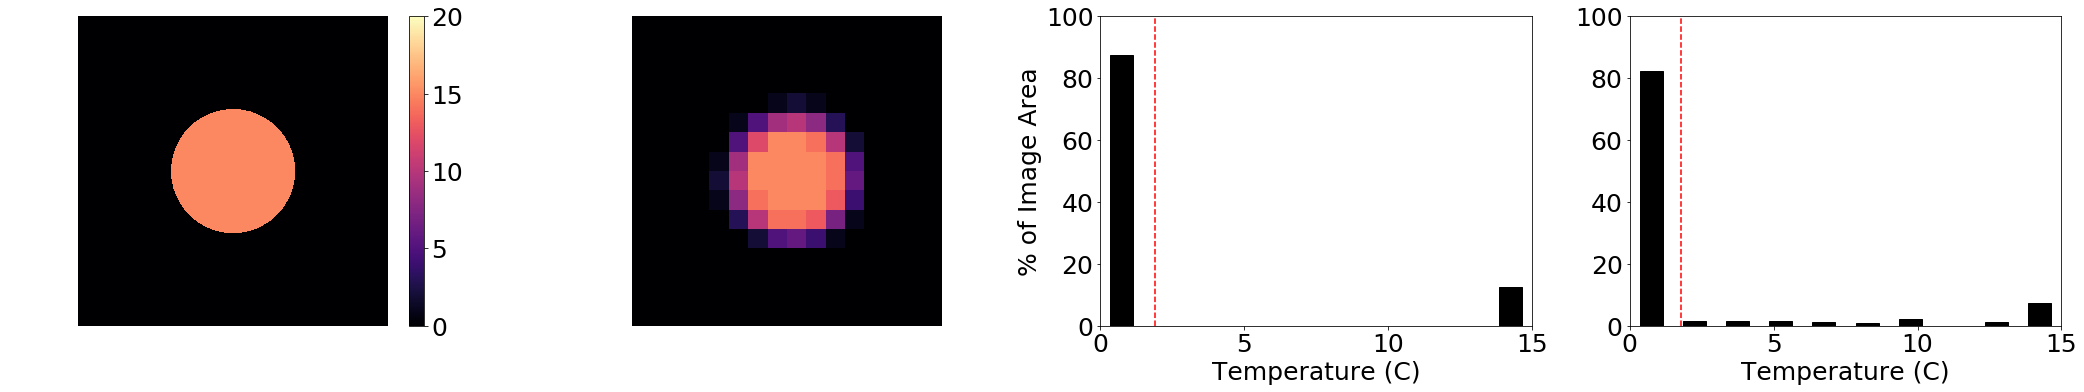

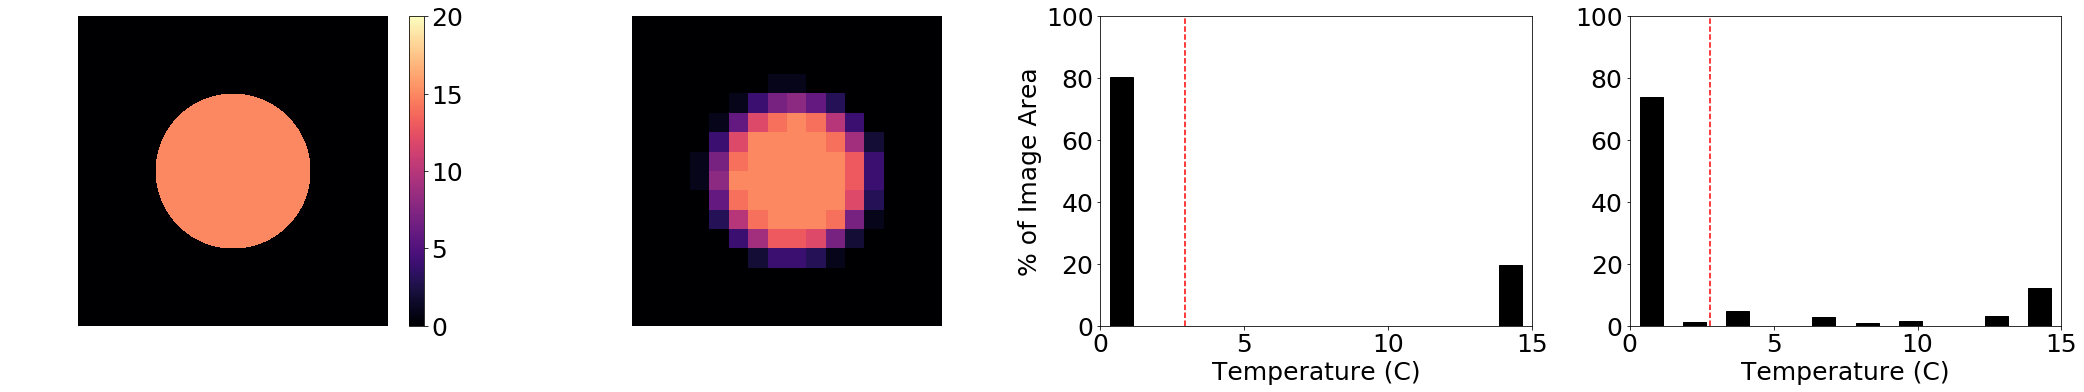

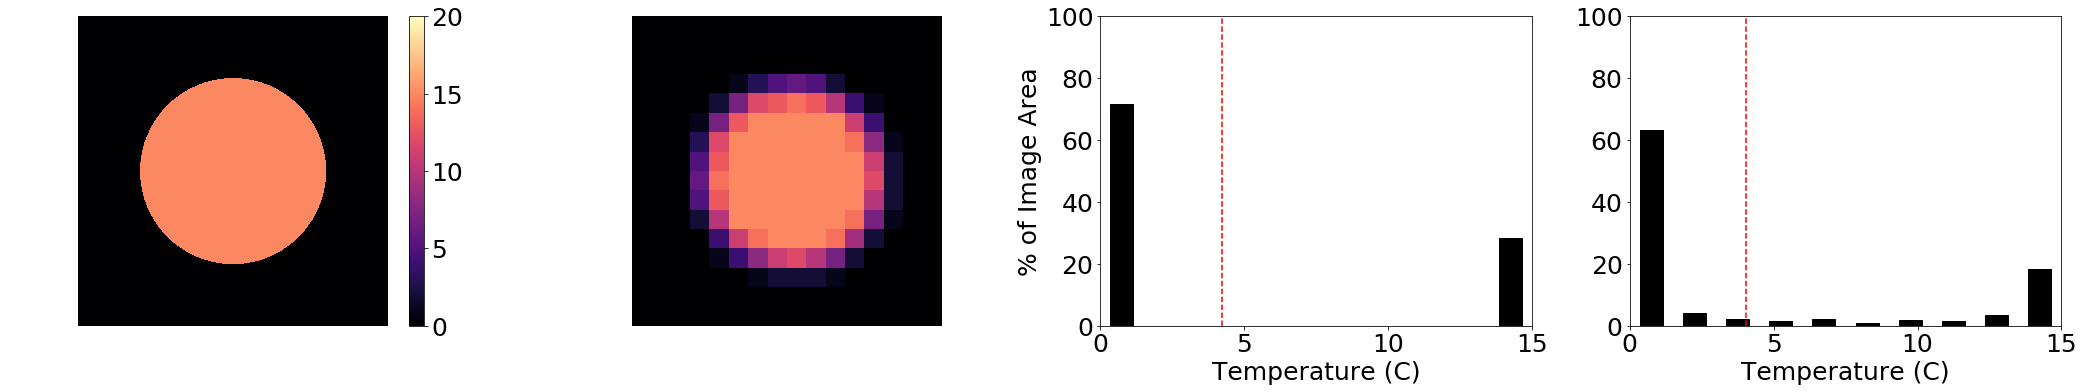

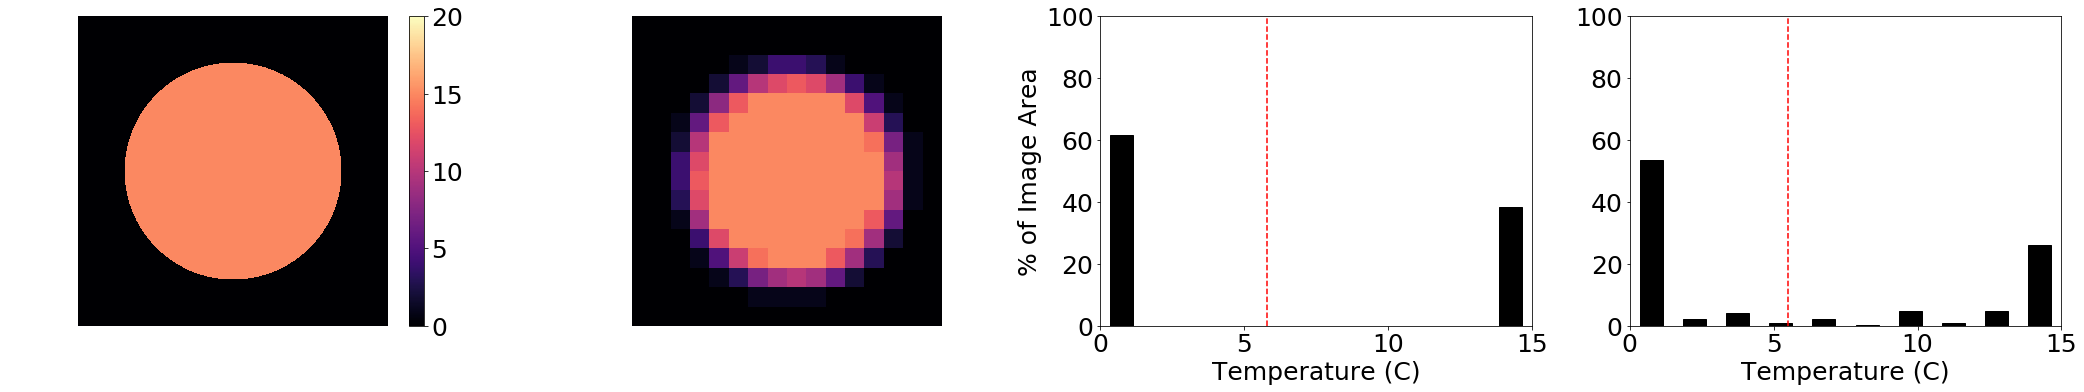

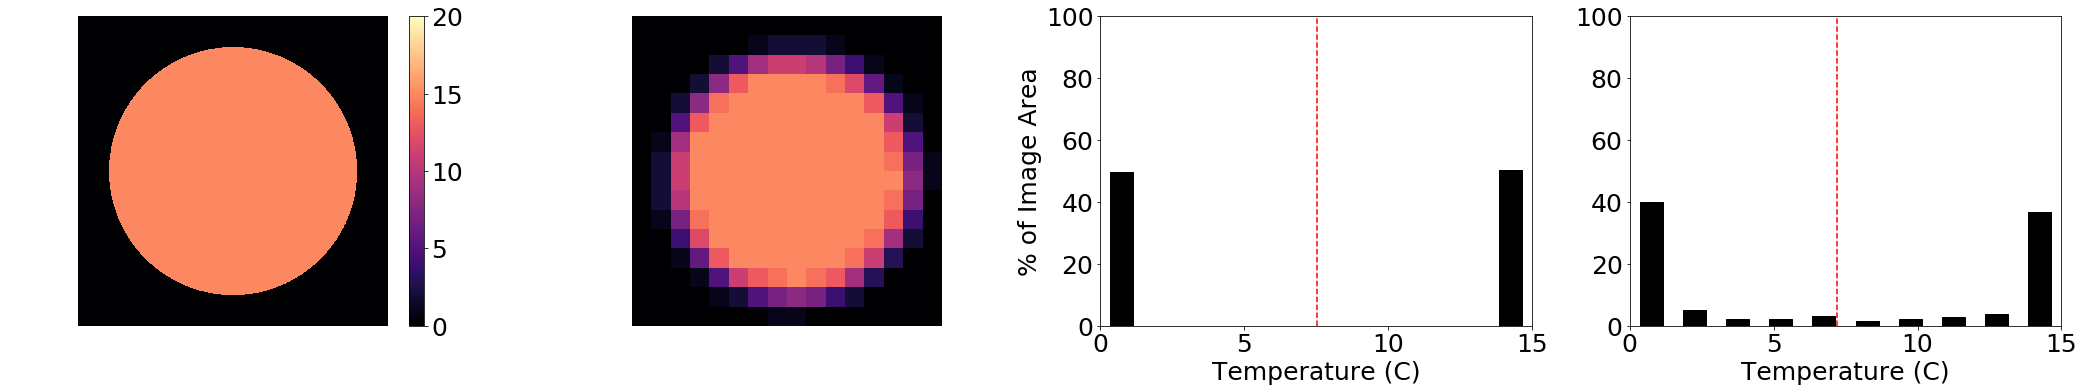

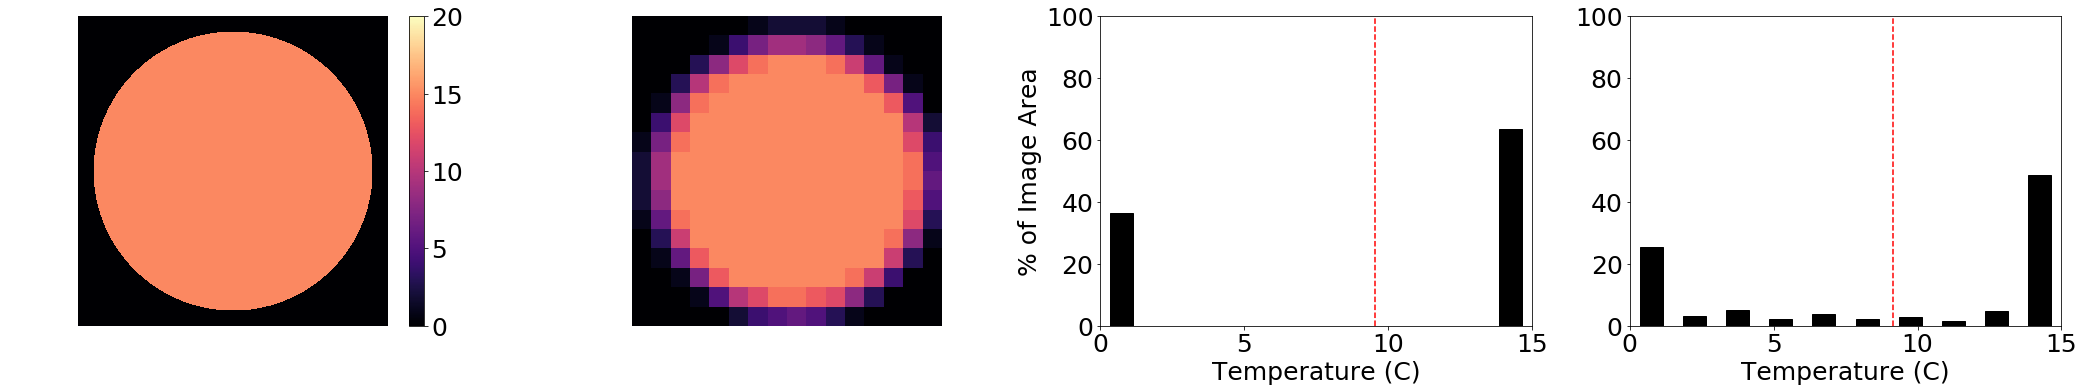

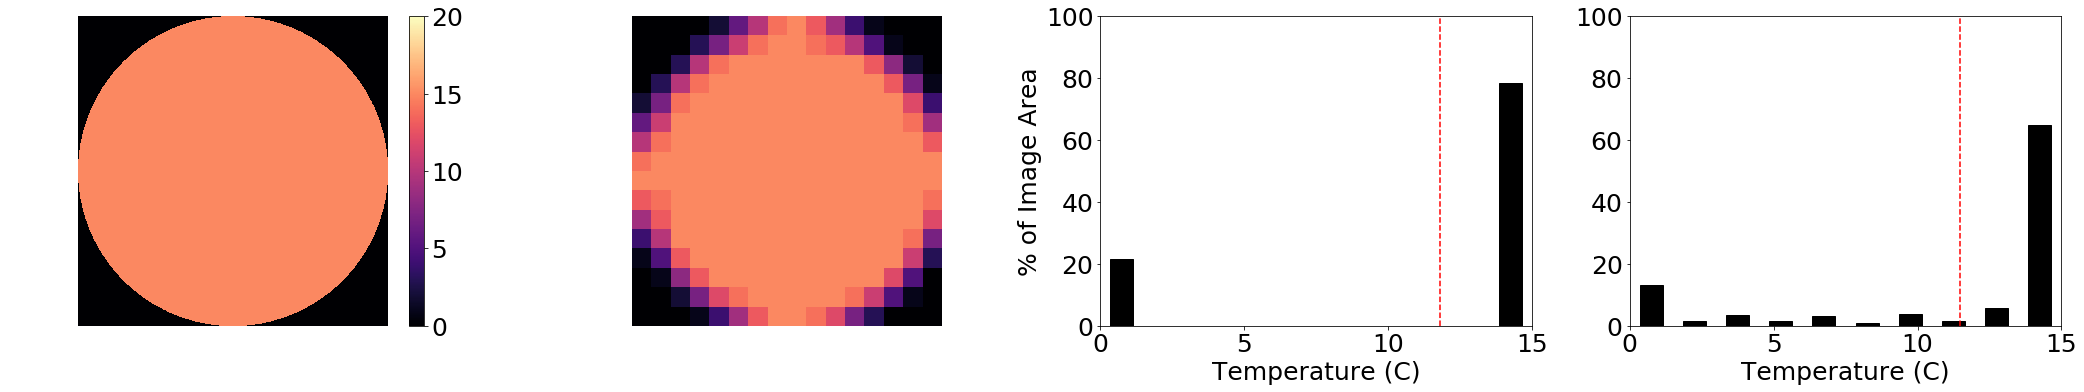

In [6]:
background_value = 0
object_value = 15


width = 2000 # units = cm
height = 2000 # units = cm

# tree radius
radii = [100,200,300,400,500,600,700,800,900,1000]

steps = [0];

# what resolution scales to test (doubling each step)
res_set = [128]

# n by n grid of trees
n_trees = np.arange(0,1,1)

# fractional vegetation area (use binary mask of original image to define)
fveg = []
# edge length
edge_ratio = []

plot_figures_original = True
plot_figures_gaussian = True
# update plot parameters
plt.rcParams.update({'font.size': 25})

counter = 0;
for radius in radii:
    for n in n_trees:

        image_area = width * height # total area of the image
        tree_area = np.pi * (radius**2) # the area of one single tree
        tree_circumf = 2 * np.pi * radius
        veg_area = (tree_area * (n)**2) + (tree_area * n * 2) + tree_area # sum of all tree areas
        fveg_area = veg_area / image_area # calculate fveg
        fveg.append(fveg_area) # append to fveg array
        edge_ratio.append(veg_area/tree_circumf)
        print('fveg:',fveg[counter])

        # make this image with n by n trees
        image = [[background_value for _ in range(height)] for _ in range(width)]
        image = np.array(image)
        image = image.astype(np.uint8)
        image = make_single_tree(image,radius,object_value)
        
        # get the original image temperature values for gaussian upscaling
        mean_temp = [np.mean(image)]
        median_temp = [np.median(image)]
        std_temp = [np.std(image)]
        min_temp = [np.min(image)]
        max_temp = [np.max(image)]
        target_temp = [image[int(image.shape[0]/2),int(image.shape[1]/2)]];
        mixed_fraction = [0]

        
        if plot_figures_original == True:
            plt.figure(figsize=(30,6))
            plt.subplot(141)
            plt.imshow(image,cmap='magma',vmin=0,vmax=20)
            #plt.title('$F_{veg}$ = '+str(np.round(fveg[counter],2))+ ' | MeanT = ' + str(np.round(mean_temp[0],2)));
            cb = plt.colorbar() # set up colorbar:
            tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator
            cb.update_ticks()
            plt.axis('off')
            plt.subplot(143)
            # make histogram
            count, value = np.histogram(image, bins=10); 
            percent = (count/(image.shape[0]*image.shape[1]))*100
            new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
            value = new_value
            #plt.plot(value,percent,'k--',label='True Surface Temperatures')
            plt.bar(value, percent, width=0.8, color='k', edgecolor='k')
            plt.plot(np.linspace(np.mean(image),np.mean(image),2),np.linspace(0,100,2),'r--')
            #plt.title('Mean: ' + str(np.round(np.mean(image),2)))
            plt.xticks([0,5,10,15])
            plt.ylim((0,100)); plt.xlim((0,15)); plt.ylabel('% of Image Area'); plt.xlabel('Temperature (C)')
        

        # upscale this image
        for res in res_set: # go from px resolution of 1 to target resolution of res
            image_upscaled, _ = upscaling_routines(image,1,res,make_plots=False);
            
            # Get the upscaled temperature values
            mean_temp.append(np.mean(image_upscaled))
            median_temp.append(np.median(image_upscaled))
            std_temp.append(np.std(image_upscaled))
            min_temp.append(np.min(image_upscaled))
            max_temp.append(np.max(image_upscaled))
            target_temp.append(image_upscaled[int(image_upscaled.shape[0]/2),int(image_upscaled.shape[1]/2)])
            mixed_fraction.append(len(image_upscaled[(image_upscaled>1)&(image_upscaled<10)])/len(image_upscaled[image_upscaled>1]))
            print('mixed fraction:',mixed_fraction)

            # Calculate approx pixel size in meters
            pixel_size = np.round((width/np.ceil(width/res))/100,2)
            edge_r = np.round(edge_ratio[counter],2)
            print('edge ratio:',edge_r)
            
            #plt.figure(999)
            #plt.plot(edge_r,mixed_fraction[1],'.k')

            if plot_figures_gaussian == True:
                #plt.figure()
                # gaussian upscaled image
                plt.subplot(142)
                plt.imshow(image_upscaled,cmap='magma',vmin=0,vmax=20)
                #plt.title('$F_{veg}$ = '+str(np.round(fveg[counter],2))+ ' | MeanT = ' + str(np.round(mean_temp[1],2)));
                #plt.colorbar()
                plt.axis('off')
                plt.subplot(144)
                # make histogram
                count, value = np.histogram(image_upscaled, bins=10); 
                percent = (count/(image_upscaled.shape[1]*image_upscaled.shape[1]))*100
                new_value = [(i+value[idx+1])/2 for idx, i in enumerate(value) if idx < len(value)-1]
                value = new_value
                #plt.plot(value,percent,'k-',label='Observed Surface Temperatures')
                plt.bar(value, percent, width=0.8, color='k', edgecolor='k')
                plt.plot(np.linspace(np.mean(image_upscaled),np.mean(image_upscaled),2),np.linspace(0,100,2),'r--')
                #plt.title('Mean: ' + str(np.round(np.mean(image_upscaled),2)))
                plt.xticks([0,5,10,15])
                plt.ylim((0,100)); plt.xlim((0,15)); # plt.ylabel('Percent of Image Area'); 
                plt.xlabel('Temperature (C)')
                
                plt.tight_layout()
                #plt.savefig('fveg'+str(np.round(fveg[counter],2))+ '_upscaled_withHistogram_' + str(res) + '.png'

        counter = counter + 1;

